In [1]:
%matplotlib widget
from diffSPH.v2.parameters import parseDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleParticles
from diffSPH.v2.util import countUniqueEntries, printState
from diffSPH.v2.plotting import updatePlot, visualizeParticles, prepVisualizationState

from diffSPH.v2.modules.integration import integrate
from diffSPH.v2.modules.neighborhood import neighborSearch
from diffSPH.v2.modules.shifting import solveShifting
from diffSPH.v2.modules.timestep import computeTimestep

from diffSPH.v2.simulationSchemes.deltaPlus import simulationStep    
from diffSPH.v2.modules.viscosity import computeViscosityParameter, setViscosityParameters
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import copy
import os
import datetime
from diffSPH.v2.util import computeStatistics
import tomli

In [2]:
configurationFile = './configurations/01_tgv.toml'

with open(configurationFile, 'r') as f:
    config = f.read()

config = tomli.loads(config)

In [3]:
# config

In [4]:
nx = 128
L = 1
u_mag = 2
k = 1 * np.pi
TGV_override = False
targetRe = 2000

config['domain']['minExtent'] = -L
config['domain']['maxExtent'] =  L
config['simulation'] = {'correctArea': True}

config['particle'] = {'nx' : nx}
config['fluid'] = {'cs' : u_mag * 10}
config['compute'] = {'device': 'cuda'}
config['plot']['export'] = True
config['kernel'] = {'name': 'Wendland4'}
# config['kernel']['targetNeighbors'] = 100
# config['compute'] = {'device': 'cpu'}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)
setViscosityParameters(config, targetRe, L, u_mag)
config['integration']['scheme'] = 'symplecticEuler'
config['integration']['scheme'] = 'semiImplicitEuler'

# print(config['kernel'])

print(rf'Re = {config["diffusion"]["Re"]}, $\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$, $\alpha = {config["diffusion"]["alpha"]}$')


$\alpha = 0.009433431170699188$ is very low, consider increasing the value (should be > 0.01)
Re = 2000.0, $\nu_{sph} = 0.002$, $\alpha = 0.009433431170699188$


In [5]:

from torch.profiler import profile, record_function, ProfilerActivity
from diffSPH.v2.modules.inletOutlet import processInlet, processOutlet, processForcing
from diffSPH.v2.plotting import plotRegions
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict
from diffSPH.v2.sampling import find_contour

ngrid = 255
x = torch.linspace(config['domain']['minExtent'][0], config['domain']['maxExtent'][0], ngrid, dtype = torch.float32)
y = torch.linspace(config['domain']['minExtent'][1], config['domain']['maxExtent'][1], ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1/2]).to(points.device))
inletSDF = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)


sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/8,1]).to(points.device))
outletSDF = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/8,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([1/4,1.5]).to(points.device))
outletRegion = operatorDict['translate'](sphere_b, torch.tensor([2 - 1/4,0.]))
# fx = sdf(torch.clone(points)).to('cpu').reshape(ngrid,ngrid)

inner = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
outer = lambda points: getSDF('box')['function'](points, torch.tensor([1 + config['particle']['dx'] * boundary_width,1 + config['particle']['dx'] * boundary_width]).to(points.device))
outer = operatorDict['invert'](outer)
sdf = operatorDict['union'](inner, outer)
boundary_sdf = operatorDict['invert'](inner)


fluid_sdf = lambda points: getSDF('box')['function'](points, torch.tensor([1,1]).to(points.device))
# fluid_sdf = operatorDict['translate'](sphere_b, torch.tensor([-2 + 1/2, - 1/2]))


regions = [
{
        'sdf': fluid_sdf,
        'type': 'fluid',
        'velocity': torch.tensor([0.,0.]),
        # 'particles': sampleParticles(config, sdfs = [fluid_sdf])[0],
        'contour': find_contour(fluid_sdf(points).reshape(ngrid, ngrid).cpu(), config['domain']['minExtent'].cpu(), config['domain']['maxExtent'].cpu(), ngrid, 0)
    }
    ]

config['regions'] = regions


In [6]:
from diffSPH.v2.sampling import sampleNoisyParticles
from diffSPH.v2.modules.divergence import computeDivergence
from diffSPH.v2.plotting import plotSDF
from diffSPH.v2.sdf import getSDF, operatorDict

# particleState, mask = sampleParticles(config, sdfs = [])
particleState, mask = sampleNoisyParticles(config['noise'], config, sdfs = regions, randomizeParticles = False)

priorState = None
particleState['velocities'][:,0] =  u_mag * torch.cos(k * particleState['positions'][:,0]) * torch.sin(k * particleState['positions'][:,1])
particleState['velocities'][:,1] = -u_mag * torch.sin(k * particleState['positions'][:,0]) * torch.cos(k * particleState['positions'][:,1])

# u_max = torch.linalg.norm(particleState['velocities'], dim = 1).max()
# particleState['velocities'] = particleState['velocities'] / (u_max + 1e-7) * u_mag
Ek0 = 0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(particleState['velocities'], dim = -1)**2

initialVelocities = particleState['velocities'].clone()

particleState['Eks'] =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2)
particleState['E_k'] = particleState['Eks'].sum().cpu().detach().item()


In [7]:
from diffSPH.v2.simulationSchemes.dfsph import simulationStep
from diffSPH.v2.modules.momentumEquation import computeMomentumEquation
from diffSPH.v2.modules.neighborhood import searchNeighbors

from diffSPH.v2.sampling import generateInitialConditions

# initialState = generateInitialConditions(particleState, config)
initialState = {
    'fluid': particleState,
    'time': 0.0,
    'timestep': 0,
    'dt': torch.tensor(5e-4, device = config['compute']['device']),
}

initialState['fluid']['velocities'][:,0] =  u_mag * torch.cos(k * initialState['fluid']['positions'][:,0]) * torch.sin(k * initialState['fluid']['positions'][:,1])
initialState['fluid']['velocities'][:,1] = -u_mag * torch.sin(k * initialState['fluid']['positions'][:,0]) * torch.cos(k * initialState['fluid']['positions'][:,1])


perennialState = copy.deepcopy(initialState)
config['dfsph']['maxIters'] = 512
config['dfsph']['errorThreshold'] = 5e-4
config['dfsph']['omega'] = 0.33

config['timestep']['dt'] = 1e-3
perennialState['dt'] = 1e-3

priorState = None
perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
perennialState['time'] += perennialState['dt']

searchNeighbors(perennialState, config)
div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)

In [8]:
from diffSPH.v2.simulationSchemes.dfsph import callModule, computeDensity, computeGravity, computeViscosity, sphOperationStates, scatter_sum
solverState = copy.deepcopy(initialState)


In [9]:

solverState['fluid']['velocities'][:,0] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10
solverState['fluid']['velocities'][:,1] =  -torch.clamp(1 - (solverState['fluid']['positions'][:,0]**2 + solverState['fluid']['positions'][:,1]**2), min = 0) * 10

In [10]:
searchNeighbors(solverState, config)
solverState['dt'] = 0.01
config['timestep']['dt'] = 0.01

solverState['fluid']['densities'], _ = callModule(solverState, computeDensity, config, 'fluid')
solverState['fluid']['gravityAccel'] = computeGravity(solverState['fluid'], config)
solverState['fluid']['velocityDiffusion'], _ = callModule(solverState, computeViscosity, config, 'fluid')

In [11]:
# solverState['fluid']['advection'] = torch.zeros_like(solverState['fluid']['gravityAccel'])

solverState['fluid']['advection'] = solverState['fluid']['gravityAccel'] + solverState['fluid']['velocityDiffusion']
solverState['fluid']['advectionVelocities'] = solverState['fluid']['velocities'] + solverState['fluid']['advection'] * solverState['dt']

In [12]:
def computeAdvectionDivergence(stateA, stateB, neighborhood, simConfig):
    with record_function("[SPH] - Fluid Divergence ($nabla cdot \\bar{v}$)"):
        divergence = sphOperationStates(stateA, stateB, (stateA['advectionVelocities'], stateB['advectionVelocities']), neighborhood=neighborhood, operation='divergence')
        return divergence
    

solverState['fluid']['velocityDivergence'] = computeDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)
solverState['fluid']['advectionDivergence'] = computeAdvectionDivergence(solverState['fluid'], solverState['fluid'], solverState['fluid']['neighborhood'], config)


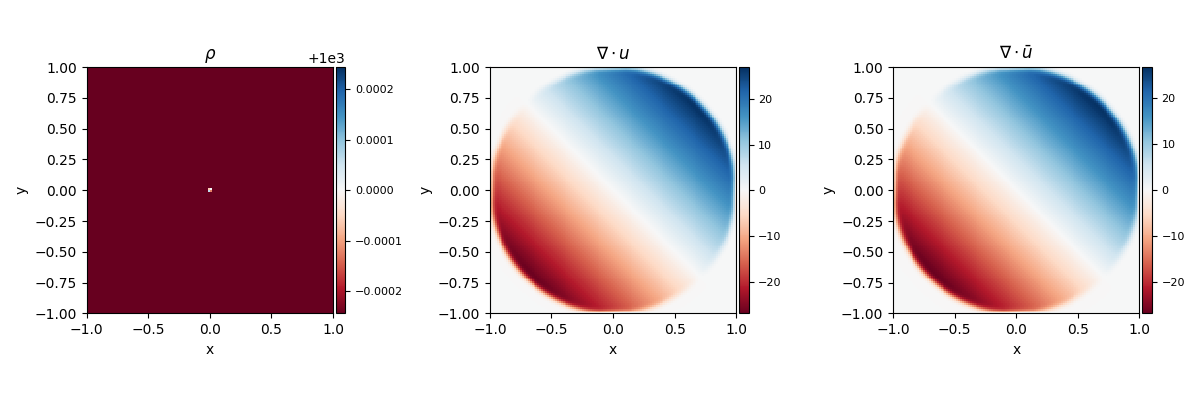

In [13]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

# xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
#                                       'velocities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = 'x-Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'y-Velocity', plotBoth = False, which = 'fluid', midPoint = 0)

# velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
#                                       'velocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = '|Velocity|', plotBoth = False, which = 'fluid', midPoint = 0)

# xVelPlot = visualizeParticleQuantity(fig, axis[1,0], config, visualizationState, quantity =
#                                       'advectionVelocities',
#                                       mapping = '.x', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = 'x-Advection', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
# yVelPlot = visualizeParticleQuantity(fig, axis[1,1], config, visualizationState, quantity = 
#                                       'advectionVelocities',
#                                       mapping = '.y', s = s, 
#                           scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'y-Advection', plotBoth = False, which = 'fluid', midPoint = 0)

# velPlot = visualizeParticleQuantity(fig, axis[1,2], config, visualizationState, quantity = 
#                                       'advectionVelocities',
#                                       mapping = 'L2', s = s, 
#                           scaling = 'lin', gridVisualization=True, cmap = 'viridis', streamLines = True, operation = None, title = '|Advection|', plotBoth = False, which = 'fluid', midPoint = 0)

xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'densities',
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$\\rho$', which = 'fluid', plotBoth = False, midPoint = 1000, streamLines = False)
yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocityDivergence',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u$', plotBoth = False, which = 'fluid', midPoint = 0)

velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      'advectionDivergence',
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot \\bar u$', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



In [70]:
solverState['pressures'] = torch.zeros_like(solverState['fluid']['densities'])

In [71]:
stateA = solverState['fluid']
stateB = solverState['fluid']
neighborhood = stateA['neighborhood']

i,j = neighborhood['indices']
rij = neighborhood['distances']
hij = neighborhood['supports']
xij = neighborhood['vectors']
gradKernels = neighborhood['gradients']
pA = stateA['pressures']
pB = stateB['pressures']

quotient = (rij * hij + 1e-7 * hij)
kernelApproximation = torch.linalg.norm(gradKernels, dim = -1) /  quotient
kernelApproximation = torch.einsum('nd, nd -> n', gradKernels, -xij)/  quotient# * rij * hij

In [72]:
Aij = pA[i] - pB[j]
massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])
dimTerm = config['domain']['dim'] * 2 + 2

laplacianTerm = dimTerm * massTerm * kernelApproximation

aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

AttributeError: 'csr_matrix' object has no attribute 'psolve'

In [77]:
Aij = pA[i] - pB[j]
massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])
dimTerm = config['domain']['dim'] * 2 + 2

laplacianTerm = dimTerm * massTerm * kernelApproximation

aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

mask = i == j

A = laplacianTerm
A[mask] = aii

B = solverState['fluid']['advectionDivergence']

In [ ]:
# def make_system(A, M, x0, b):
#     """Make a linear system Ax=b

#     Parameters
#     ----------
#     A : LinearOperator
#         sparse or dense matrix (or any valid input to aslinearoperator)
#     M : {LinearOperator, Nones}
#         preconditioner
#         sparse or dense matrix (or any valid input to aslinearoperator)
#     x0 : {array_like, str, None}
#         initial guess to iterative method.
#         ``x0 = 'Mb'`` means using the nonzero initial guess ``M @ b``.
#         Default is `None`, which means using the zero initial guess.
#     b : array_like
#         right hand side

#     Returns
#     -------
#     (A, M, x, b, postprocess)
#         A : LinearOperator
#             matrix of the linear system
#         M : LinearOperator
#             preconditioner
#         x : rank 1 ndarray
#             initial guess
#         b : rank 1 ndarray
#             right hand side
#         postprocess : function
#             converts the solution vector to the appropriate
#             type and dimensions (e.g. (N,1) matrix)

#     """
#     A_ = A
#     A = aslinearoperator(A)

#     if A.shape[0] != A.shape[1]:
#         raise ValueError(f'expected square matrix, but got shape={(A.shape,)}')

#     N = A.shape[0]

#     b = asanyarray(b)

#     if not (b.shape == (N,1) or b.shape == (N,)):
#         raise ValueError(f'shapes of A {A.shape} and b {b.shape} are '
#                          'incompatible')

#     if b.dtype.char not in 'fdFD':
#         b = b.astype('d')  # upcast non-FP types to double

#     def postprocess(x):
#         return x

#     if hasattr(A,'dtype'):
#         xtype = A.dtype.char
#     else:
#         xtype = A.matvec(b).dtype.char
#     xtype = coerce(xtype, b.dtype.char)

#     b = asarray(b,dtype=xtype)  # make b the same type as x
#     b = b.ravel()

#     # process preconditioner
#     if M is None:
#         if hasattr(A_,'psolve'):
#             psolve = A_.psolve
#         else:
#             psolve = id
#         if hasattr(A_,'rpsolve'):
#             rpsolve = A_.rpsolve
#         else:
#             rpsolve = id
#         if psolve is id and rpsolve is id:
#             M = IdentityOperator(shape=A.shape, dtype=A.dtype)
#         else:
#             M = LinearOperator(A.shape, matvec=psolve, rmatvec=rpsolve,
#                                dtype=A.dtype)
#     else:
#         M = aslinearoperator(M)
#         if A.shape != M.shape:
#             raise ValueError('matrix and preconditioner have different shapes')

#     # set initial guess
#     if x0 is None:
#         x = zeros(N, dtype=xtype)
#     elif isinstance(x0, str):
#         if x0 == 'Mb':  # use nonzero initial guess ``M @ b``
#             bCopy = b.copy()
#             x = M.matvec(bCopy)
#     else:
#         x = array(x0, dtype=xtype)
#         if not (x.shape == (N, 1) or x.shape == (N,)):
#             raise ValueError(f'shapes of A {A.shape} and '
#                              f'x0 {x.shape} are incompatible')
#         x = x.ravel()

#     return A, M, x, b, postprocess

In [165]:
# Convert lp2 to COO format
lp2_coo = lp2.tocoo()

# Get the values and indices
values = lp2_coo.data
row_indices = lp2_coo.row
col_indices = lp2_coo.col

H_sp = torch.tensor(values, dtype = torch.float64)
B_sp = torch.tensor(rhs, dtype = torch.float64)
i_sp = torch.tensor(row_indices, dtype = torch.int64)
j_sp = torch.tensor(col_indices, dtype = torch.int64)
x0_sp = torch.zeros_like(B_sp)

In [187]:
random_mat = lp2.copy()
random_mat.data = np.random.rand(random_mat.data.size)
H_sp = torch.tensor(random_mat.data, dtype = torch.float64)

In [202]:
A_op = scipy.sparse.linalg.aslinearoperator(random_mat)
matvec, rmatvec = A_op.matvec, A_op.rmatvec

x0 = np.random.rand(lp2.shape[0])

M_precond = H_sp.new_ones(B_sp.shape[0])
M_i = torch.arange(B_sp.shape[0])
M_j = torch.arange(B_sp.shape[0])


In [205]:
A_coo = (H_sp, (i_sp, j_sp), B_sp.shape[0])
M_coo = (M_precond, (M_i, M_j), B_sp.shape[0])

In [189]:
matvec(x0)

array([0.7005296 , 1.47871397, 1.59099223, ..., 0.40105167, 0.80408309,
       1.31059623])

In [233]:

from typing import Optional, Tuple

def matvec_sparse_coo(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], x):
    return scatter_sum(A[0] * x[A[1][1]], A[1][0], dim = 0, dim_size = x.shape[0]) 

def rmatvec_sparse_coo(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], x):
    return scatter_sum(A[0] * x[A[1][0]], A[1][1], dim = 0, dim_size = x.shape[0]) 

def make_id(A : Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int]):
    M_precond = A[0].new_ones(A[2])
    M_i = torch.arange(A[2]).to(M_precond.device).to(torch.int64)
    M_j = torch.arange(A[2]).to(M_precond.device).to(torch.int64)

    return (M_precond, (M_i, M_j), A[2])

In [199]:
torch.finfo(x0_sp.dtype).eps

2.220446049250313e-16

In [214]:
torch.zeros_like(B_sp)

tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)

In [234]:
def _get_atol_rtol(name:str, b_norm:float, atol:float=0., rtol:float=1e-5):
    """
    A helper function to handle tolerance normalization
    """
    # if atol == 'legacy' or atol is None or atol < 0:
    #     msg = (f"'scipy.sparse.linalg.{name}' called with invalid `atol`={atol}; "
    #            "if set, `atol` must be a real, non-negative number.")
    #     raise ValueError(msg)

    atol = max(float(atol), float(rtol) * float(b_norm))

    return atol, rtol
def _get_tensor_eps(
    x: torch.Tensor,
    eps16: float = torch.finfo(torch.float16).eps,
    eps32: float = torch.finfo(torch.float32).eps,
    eps64: float = torch.finfo(torch.float64).eps,
) -> float:
    if x.dtype == torch.float16:
        return eps16
    elif x.dtype == torch.float32:
        return eps32
    elif x.dtype == torch.float64:
        return eps64
    else:
        raise RuntimeError(f"Expected x to be floating-point, got {x.dtype}")
    
@torch.jit.script
def bicg(A: Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor], int], b, x0:Optional[torch.Tensor]=None, rtol:float=1e-5, atol:float=0., maxiter:Optional[int]=None, M:Optional[Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor],int]]=None, maxIter: int = 512, tol: float = 1e-5):
    # A, M, x, b, postprocess = make_system(A, M, x0, b)
    if M is None:
        M = make_id(A)
    x = x0.clone() if x0 is not None else torch.zeros_like(b)
    bnrm2 = torch.linalg.norm(b)

    atol, _ = _get_atol_rtol('bicg', bnrm2, atol, rtol)

    convergence = []
    
    if bnrm2 == 0:
        return b, 0, convergence
        # return postprocess(b), 0

    n = len(b)
    dotprod = torch.dot

    if maxiter is None:
        maxiter = n*10

    # matvec, rmatvec = A.matvec, A.rmatvec
    # psolve, rpsolve = M.matvec, M.rmatvec
    # print(torch.finfo(x.dtype).eps**2)
    rhotol = _get_tensor_eps(x)**2
    # print(rhotol)

    # # Dummy values to initialize vars, silence linter warnings
    # rho_prev, p, ptilde = r.clone(), r.clone(), r.clone()
    rho_prev = torch.zeros_like(b)
    p = torch.zeros_like(b)
    ptilde = torch.zeros_like(b)

    r = b - matvec_sparse_coo(A, x) if x.any() else b.clone()

    # return r, 0 , convergence
    rtilde = r.clone()

    for iteration in range(maxiter):
        if torch.linalg.norm(r) < atol:  # Are we done?
            return x, 0 , convergence

        print()

        z = matvec_sparse_coo(M, r)
        ztilde = rmatvec_sparse_coo(M, rtilde)
        # order matters in this dot product
        rho_cur = dotprod(rtilde, z)

        if torch.abs(rho_cur) < rhotol:  # Breakdown case
            return x, -10, convergence

        if iteration > 0:
            beta = rho_cur / rho_prev
            p *= beta
            p += z
            ptilde *= beta.conj()
            ptilde += ztilde
        else:  # First spin
            p = z.clone()
            ptilde = ztilde.clone()

        q = matvec_sparse_coo(A, p)
        qtilde = rmatvec_sparse_coo(A, ptilde)
        rv = dotprod(ptilde, q)

        if rv == 0:
            return x, -11, convergence

        alpha = rho_cur / rv
        x += alpha*p
        r -= alpha*q
        rtilde -= alpha.conj()*qtilde
        rho_prev = rho_cur

        # if callback:
            # callback(x)

    # else:  # for loop exhausted
        # Return incomplete progress
    return x, maxiter, convergence


r, iters, convergence = bicg(A_coo, B_sp, x0_sp, tol =1e-5, maxIter = 512)

print('r: ', r)
print('iters: ', iters)
print('convergence: ', convergence)

: 

: 

In [ ]:
H_sp = torch.tensor(values, dtype = torch.float64)
B_sp = torch.tensor(rhs, dtype = torch.float64)
i_sp = torch.tensor(row_indices, dtype = torch.int64)
j_sp = torch.tensor(col_indices, dtype = torch.int64)
x0_sp = torch.zeros_like(B_sp)

xk_sp, convergence_sp, num_iter_sp, residual_sp = bicg(H_sp, B_sp, x0_sp, i_sp, j_sp, tol =1e-5, maxIter = 512)

In [147]:
@torch.jit.script
def BiCG(H, B, x0, i, j, tol : float =1e-5, maxIter : int = 32):
    with record_function("[Shifting] - BiCG Solver"):
        xk = x0
        rk = torch.zeros_like(x0)
        numParticles = rk.shape[0] 

        rk  += scatter_sum(H * xk[j], i, dim=0, dim_size=numParticles)
        
        rk = B - rk
        r0 = rk.clone()
        pk = rk.clone()
        
        num_iter = 0
        convergence = []
        rk_norm = torch.linalg.norm(rk)
        while (torch.abs(torch.linalg.norm(rk) / rk_norm - 1) > 1e-4 or num_iter == 0) and num_iter < maxIter and torch.linalg.norm(rk) > tol:
            rk_norm = torch.linalg.norm(rk)
            apk = torch.zeros_like(x0)

            apk+= scatter_sum(H * pk[j], i, dim=0, dim_size=numParticles)

            alpha = torch.dot(rk, r0) / torch.dot(apk, r0)
            xk = xk + alpha * pk
            rk = rk - alpha * apk

            beta = torch.dot(rk, r0) / torch.dot(r0, r0)
            pk = rk + beta * pk
            
            num_iter += 1
            convergence.append(torch.linalg.norm(rk))

        return xk, convergence, num_iter, torch.linalg.norm(rk)


In [116]:
def BiCGStab_wJacobi(H, B, x0, i, j, tol : float =1e-5, maxIter : int = 32):
    with record_function("[Shifting] - BiCGStab Solver w/ Jacobi Preconditioner"):
        xk = x0
        rk = torch.zeros_like(x0)
        numParticles = rk.shape[0]
        ii = torch.unique(i)
        # Calculate the Jacobi preconditioner
        diag = H[i == j]

        # diag = torch.vstack((H[i == j, 0, 0], H[i == j, 1, 1])).flatten()
        # diag[diag < 1e-8] = 1
        M_inv = 1 / diag
        M_inv[diag < 1e-8] = 0
        # M_inv[torch.isnan(M_inv)] = 1

        rk = scatter_sum(H * xk[j], i, dim=0, dim_size=numParticles)
        rk = B - rk
        r0 = rk.clone()

        # Apply the preconditioner
        # zk = torch.bmm(M_inv, rk.unsqueeze(-1)).squeeze(-1)
        # print(f'i: {i.shape} x j: {j.shape} -> {i[i==j]}, {i}, {j}')
        # print(f'rk: {rk}, M_inv: {M_inv}, @ {M_inv.shape} * {rk.shape}')
        zk = M_inv * rk
        pk = zk.clone()
        
        num_iter = 0
        convergence = []
        rk_norm = torch.linalg.norm(rk)
        while (torch.abs(torch.linalg.norm(rk) / rk_norm - 1) > 1e-3 or num_iter == 0) and num_iter < maxIter and torch.linalg.norm(rk) > tol:
            rk_norm = torch.linalg.norm(rk)
            apk = torch.zeros_like(x0)

            apk  = scatter_sum(H * pk[j], i, dim=0, dim_size=numParticles)

            alpha = torch.dot(rk, r0) / (torch.dot(apk, r0) + 1e-8)
            sk = rk - alpha * apk
            ask = torch.zeros_like(x0)

            ask = scatter_sum(H * sk[j], i, dim=0, dim_size=numParticles)

            omega = torch.dot(ask, sk) / (torch.dot(ask, ask) + 1e-8)
            # print(f'xk: {torch.linalg.norm(xk)}, pk: {torch.linalg.norm(rk)}, sk: {torch.linalg.norm(pk)}')
            # print(f'alpha * pk: {torch.linalg.norm(alpha * pk)}, omega * sk: {torch.linalg.norm(omega * sk)}')

            xk = xk + alpha * pk + omega * sk
            rk = sk - omega * ask

            # Apply the preconditioner
            zk = M_inv * rk
            beta = (torch.dot(rk, r0) / (torch.dot(r0, r0)) + 1e-8) * (alpha / (omega + 1e-8))
            pk = zk + beta * (pk - omega * apk)
            if torch.abs(alpha) < 1e-8 or torch.abs(omega) < 1e-8 or torch.abs(beta) < 1e-8:
                break

            # print('###############################################################################')
            # print(f'Iter: {num_iter}, Residual: {torch.linalg.norm(rk)}, Threshold {tol}')
            # print(f'alpha: {alpha}, omega: {omega}, beta: {beta}')
            # print(f'rk: {rk}, pk: {pk}, xk: {xk}')
            print(f'rk: {torch.linalg.norm(rk)}, xk: {torch.linalg.norm(xk)}, pk: {torch.linalg.norm(pk)}')
            # print(f'apk: {apk}, ask: {ask}')
            # print(torch.dot(rk, r0))
            # print(torch.dot(r0, r0))
            # print((alpha / omega))

            num_iter += 1
            convergence.append(torch.linalg.norm(rk))

        return xk, convergence, num_iter, torch.linalg.norm(rk)



In [151]:
import scipy as sp
import scipy
n = 250
ex = np.ones(n);
lp1 = -sp.sparse.spdiags(np.vstack((ex,  -2*ex, ex)), [-1, 0, 1], n, n, 'csr'); 
ee = scipy.sparse.eye(n, n)
res_all_nostab = []
res_all_bicg_nostab = []
res_all = []
res_all_bicg = []
res_all_nopc = []
res_all_bicg_nopc = []
lp2 = scipy.sparse.kron(lp1, ee) + scipy.sparse.kron(ee, lp1)
rhs = np.ones(n * n)

def my_print_nopc(r):
    res_all_nopc.append(r)

def my_print2_nopc(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg_nopc.append(np.linalg.norm(lp2.dot(x) - rhs))

def my_print(r):
    res_all.append(r)

def my_print2(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg.append(np.linalg.norm(lp2.dot(x) - rhs))

def my_print_nostab(r):
    res_all_nostab.append(r)

def my_print2_nostab(x): #For BiCGStab they have another callback, please rewrite
    res_all_bicg_nostab.append(np.linalg.norm(lp2.dot(x) - rhs))

    
# M = scipy.sparse.linalg.spilu(lp2, drop_tol=1e-3)
#Create prec
# lo = scipy.sparse.linalg.LinearOperator(lp2.shape, lambda x: M.solve(x))
# sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, M=lo, restart=50)

# sol2 = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2, M=lo)

D = scipy.sparse.diags(1 / lp2.diagonal())
sol = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, M=D, restart=50)

sol2 = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2, M=D)

sol_nopc = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print_nopc, restart=100)
# plt.semilogy(res_all, marker='x',label='GMRES')
sol2_nopc = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2_nopc)

sol2_nostab = scipy.sparse.linalg.bicg(lp2, rhs, callback=my_print2_nostab)
# plt.xlabel('Iteration number')
# plt.ylabel('Residual')
# plt.semilogy(res_all_bicg, label='BiCGStab', marker='o')
# plt.legend(loc='best')

In [150]:

sol2 = scipy.sparse.linalg.bicg(lp2, rhs, callback=my_print2, M=D)
# print(D.shape)

In [141]:

sol_nopc = scipy.sparse.linalg.gmres(lp2, rhs, callback=my_print, restart=100)
# plt.semilogy(res_all, marker='x',label='GMRES')
sol2_nopc = scipy.sparse.linalg.bicgstab(lp2, rhs, callback=my_print2)
# plt.xlabel('Iteration number')

In [123]:
import scipy.sparse as sp

# Convert lp2 to COO format
lp2_coo = lp2.tocoo()

# Get the values and indices
values = lp2_coo.data
row_indices = lp2_coo.row
col_indices = lp2_coo.col

In [128]:
print(values.shape, row_indices.shape, col_indices.shape)
print(lp2.shape)

(311500,) (311500,) (311500,)
(62500, 62500)


In [153]:
H_sp = torch.tensor(values, dtype = torch.float64)
B_sp = torch.tensor(rhs, dtype = torch.float64)
i_sp = torch.tensor(row_indices, dtype = torch.int64)
j_sp = torch.tensor(col_indices, dtype = torch.int64)
x0_sp = torch.zeros_like(B_sp)

xk_sp, convergence_sp, num_iter_sp, residual_sp = bicg(H_sp, B_sp, x0_sp, i_sp, j_sp, tol =1e-5, maxIter = 512)

NameError: name 'bicg' is not defined

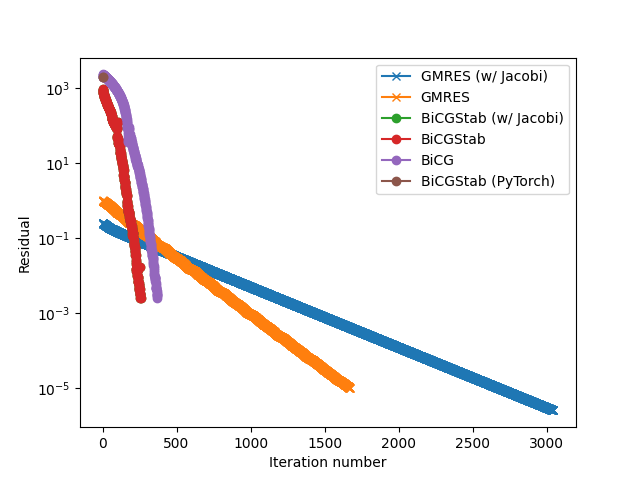

In [152]:
fig, axis = plt.subplots(1,1)

axis.semilogy(res_all, marker='x',label='GMRES (w/ Jacobi)')
axis.semilogy(res_all_nopc, marker='x',label='GMRES')
axis.set_xlabel('Iteration number')
axis.set_ylabel('Residual')
axis.semilogy(res_all_bicg, label='BiCGStab (w/ Jacobi)', marker='o')
axis.semilogy(res_all_bicg_nopc, label='BiCGStab', marker='o')
axis.semilogy(res_all_bicg_nostab, label='BiCG', marker='o')

axis.semilogy(convergence_sp, label='BiCGStab (PyTorch)', marker='o')
axis.legend(loc='best')

In [117]:
Aij = pA[i] - pB[j]
massTerm = stateA['masses'][j] / (stateA['densities'][i] + stateB['densities'][j])
dimTerm = config['domain']['dim'] * 2 + 2

laplacianTerm = dimTerm * massTerm * kernelApproximation

aii = scatter_sum(laplacianTerm, i, dim = 0, dim_size = stateA['positions'].shape[0])

mask = i == j

A = laplacianTerm
A[mask] = aii

B = solverState['fluid']['advectionDivergence'] / solverState['dt']

p, convergence, iters, residual = BiCGStab_wJacobi(A, B, torch.zeros_like(B), i, j)

print(f'Iterations: {iters}, Residual: {residual}, {convergence}')
print(f'p: {p}, min: {p.min()}, max: {p.max()}, mean: {p.mean()}')

xk: 0.0, pk: 156756.359375, sk: 15.822569847106934
alpha * pk: 7.956910133361816, omega * sk: 0.2031862586736679
rk: 510.646484375, xk: 7.959504127502441, pk: 15.113845825195312
xk: 7.959504127502441, pk: 510.646484375, sk: 15.113845825195312
alpha * pk: 0.004278724547475576, omega * sk: 0.03457466512918472
rk: 120.78671264648438, xk: 7.963969707489014, pk: 0.012210115790367126
xk: 7.963969707489014, pk: 120.78671264648438, sk: 0.012210115790367126
alpha * pk: 0.006002364680171013, omega * sk: 0.012716037221252918
rk: 56.351654052734375, xk: 7.964136123657227, pk: 0.00506383553147316
xk: 7.964136123657227, pk: 56.351654052734375, sk: 0.00506383553147316
alpha * pk: 0.0029311380349099636, omega * sk: 0.0023603388108313084
rk: 2.3451924324035645, xk: 7.964356899261475, pk: 0.00023643809254281223
xk: 7.964356899261475, pk: 2.3451924324035645, sk: 0.00023643809254281223
alpha * pk: 0.00012747751316055655, omega * sk: 9.048236825037748e-05
rk: 0.2163620889186859, xk: 7.964370250701904, pk: 

In [106]:
a_p = -sphOperationStates(stateA, stateB, (p, p), operation = 'gradient', gradientMode='summation', neighborhood= neighborhood) / stateA['densities'].view(-1,1)
finalVelocities = stateA['advectionVelocities'] + a_p * solverState['dt']
finalDivergence = sphOperationStates(stateA, stateB, (finalVelocities, finalVelocities), neighborhood=neighborhood, operation='divergence')



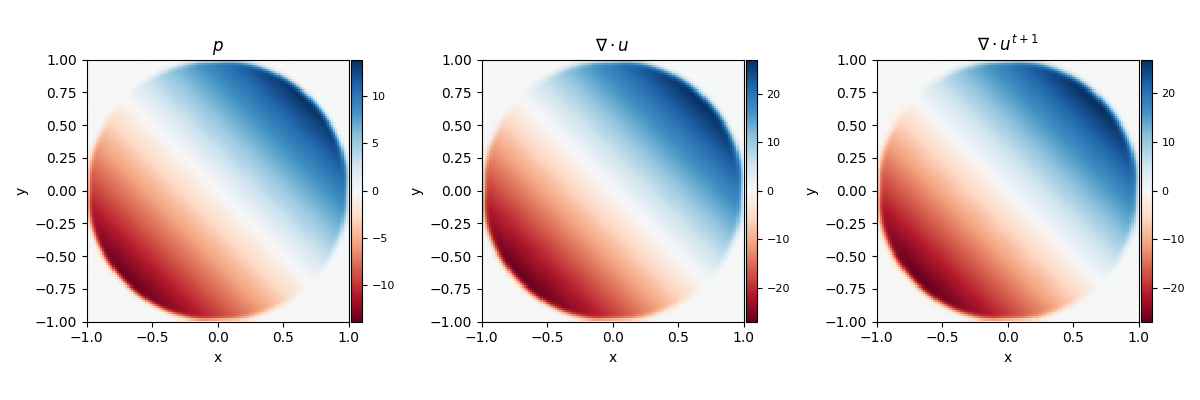

In [109]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(solverState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

xVelPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      p,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', title = '$p$', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = False)
yVelPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'velocityDivergence',
                                      mapping = '.y', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u$', plotBoth = False, which = 'fluid', midPoint = 0)

velPlot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      finalDivergence,
                                      mapping = 'L2', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = '$\\nabla \\cdot u^{t+1}$', plotBoth = False, which = 'fluid', midPoint = 0)



fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



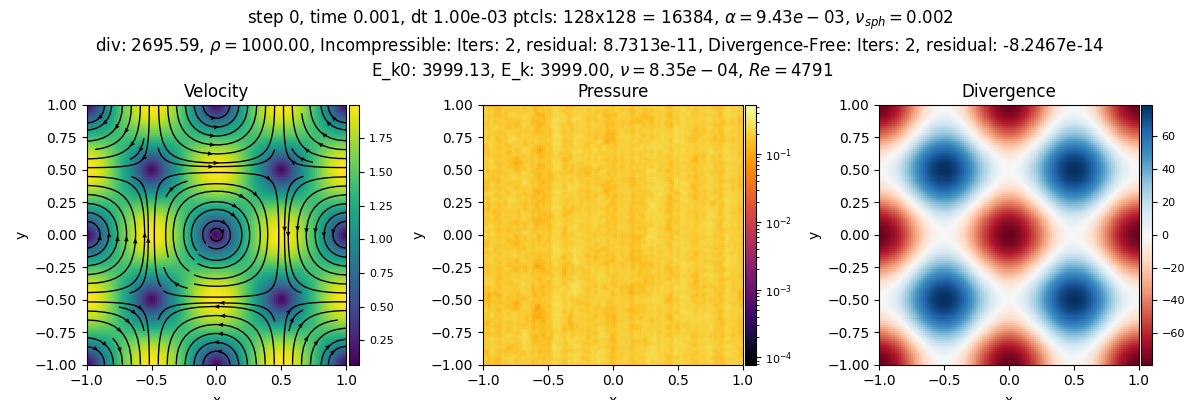

In [8]:
from diffSPH.v2.plotting import prepVisualizationState, visualizeParticleQuantity
from diffSPH.v2.plotting import exportPlot, postProcessPlot
fig, axis = plt.subplots(1,3, figsize = (12,4), squeeze = False)

visualizationState = prepVisualizationState(perennialState, config, grid = True)
# plotRegions(regions, axis[0,0])
# plotRegions(regions, axis[0,1])

s = 0.25

indexPlot = visualizeParticleQuantity(fig, axis[0,0], config, visualizationState, quantity =
                                      'velocities',
                                      mapping = 'L2', s = s, 
                          scaling = 'lin', gridVisualization=True, cmap = 'viridis', title = 'Velocity', which = 'fluid', plotBoth = False, midPoint = 0, streamLines = True)
quantPlot = visualizeParticleQuantity(fig, axis[0,1], config, visualizationState, quantity = 
                                      'pressureIncompressible',
                                      mapping = '.y', s = s, 
                          scaling = 'log', gridVisualization=True, cmap = 'inferno', streamLines = False, operation = None, title = 'Pressure', plotBoth = False, which = 'fluid', midPoint = 1000)

l2Plot = visualizeParticleQuantity(fig, axis[0,2], config, visualizationState, quantity = 
                                      div,
                                      mapping = '.x', s = s, 
                          scaling = 'sym', gridVisualization=True, cmap = 'RdBu', streamLines = False, operation = None, title = 'Divergence', plotBoth = False, which = 'fluid', midPoint = 0)

E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
Re = u_mag * 2 / nu_total

fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(priorState["fluid"]["convergence_density"])}, residual: {priorState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(priorState["fluid"]["convergence_divergence"])}, residual: {priorState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')

fig.tight_layout()

# simulationState['fluid']['actualArea'] = simulationState['fluid']['masses'] / simulationState['fluid']['densities']
# 



In [13]:
priorState = None
for i in tqdm(range(4096)):
    if 'shiftAmount' in perennialState['fluid']:
        del perennialState['fluid']['shiftAmount']
    perennialState, priorState, *updates = integrate(simulationStep, perennialState, config, previousStep= priorState)
    # dx, _ = solveShifting(perennialState, config)
    # numNeighbors = perennialState['fluid']['neighborhood']['numNeighbors']
    # perennialState['fluid']['shiftAmount'] = dx
    # perennialState['fluid']['positions'][numNeighbors > 5] += dx[numNeighbors > 5]
    # if config['compute']['checkNaN']:
    #     checkNaN(perennialState['fluid']['positions'], 'positions')
    #     checkNaN(perennialState['fluid']['shiftAmount'], 'shiftAmount')
    perennialState['time'] += perennialState['dt']
    perennialState['timestep'] += 1
    # print(f'Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}')

    if i % 128 == 0:
        searchNeighbors(perennialState, config)
        visualizationState = prepVisualizationState(perennialState, config)
        div = computeMomentumEquation(perennialState['fluid'], perennialState['fluid'], perennialState['fluid']['neighborhood'], config)
        
        # div = sphOperationStates(perennialState['fluid'], perennialState['fluid'], (perennialState['fluid']['velocities'], perennialState['fluid']['velocities']), operation = 'divergence', gradientMode='difference', neighborhood=perennialState['fluid']['neighborhood'])
        updatePlot(indexPlot, visualizationState, 'velocities')
        updatePlot(quantPlot, visualizationState, 'pressureIncompressible')
        updatePlot(l2Plot, visualizationState, div)
        
        
        E_k0 =  (0.5 * particleState['areas'] * particleState['densities'] * torch.linalg.norm(initialVelocities, dim = -1)**2).sum().detach().cpu().numpy()
        E_k = (0.5 * torch.sum(perennialState['fluid']['areas'] * perennialState['fluid']['densities'] * torch.linalg.norm(perennialState['fluid']['velocities'], dim = 1)**2)).sum().detach().cpu().numpy()
        nu_total = np.log(E_k / E_k0) / (-4 *  perennialState['time'] * k**2 )
        Re = u_mag * 2 / nu_total


        fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.4g}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]:.2e}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum():.2f}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$, Incompressible: Iters: {len(perennialState["fluid"]["convergence_density"])}, residual: {perennialState["fluid"]["convergence_density"][-1]:.4e}, Divergence-Free: Iters: {len(perennialState["fluid"]["convergence_divergence"])}, residual: {perennialState["fluid"]["convergence_divergence"][-1]:.4e}\n E_k0: {E_k0:.2f}, E_k: {E_k:.2f}, $\\nu = {nu_total:.2e}$, $Re = {Re:.4g}$')
        # fig.suptitle(f'step {perennialState["timestep"]}, time {perennialState["time"]:.2f}, dt {perennialState["dt"]:.2e} ptcls: {nx}x{nx} = {nx**2}, $\\alpha = {config["diffusion"]["alpha"]}$, $\\nu_{{sph}} = {config["diffusion"]["nu_sph"]}$\ndiv: {div.sum()}, $\\rho = {perennialState["fluid"]["densities"].mean().cpu().detach().numpy():.2f}$')

        
        
        fig.canvas.draw()
        fig.canvas.flush_events()
        exportPlot(perennialState, config, fig)



  0%|          | 0/4096 [00:00<?, ?it/s]

In [14]:

import subprocess
import shlex

outFile = config['plot']['namingScheme'] if config['plot']['namingScheme'] != 'timestep' else config["simulation"]["timestamp"]
if config['plot']['namingScheme'] == 'timestep':
    outFolder = f'{config["plot"]["exportPath"]}/{config["simulation"]["timestamp"]}/'
else:
    outFolder = f'{config["plot"]["exportPath"]}/{config["plot"]["namingScheme"]}/'

os.makedirs(outFolder, exist_ok = True)
# print('Creating video from  frames (frame count: {})'.format(len(os.listdir(outFolder))))
command = '/usr/bin/ffmpeg -loglevel warning -y -framerate 30 -f image2 -pattern_type glob -i '+ outFolder + '*.png -c:v libx264 -b:v 20M -r ' + str(config['plot']['exportFPS']) + ' ' + outFolder + 'output.mp4'
commandB = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -vf "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos,palettegen" output/palette.png'
commandC = f'ffmpeg -loglevel warning -hide_banner -y -i {outFolder}output.mp4 -i output/palette.png -filter_complex "fps={config["plot"]["exportFPS"]},scale={config["plot"]["gifScale"]}:-1:flags=lanczos[x];[x][1:v]paletteuse" {outFile}.gif'

subprocess.run(shlex.split(command))
subprocess.run(shlex.split(commandB))
subprocess.run(shlex.split(commandC))

CompletedProcess(args=['ffmpeg', '-loglevel', 'warning', '-hide_banner', '-y', '-i', 'output/2024_07_04-11_20_46/output.mp4', '-i', 'output/palette.png', '-filter_complex', 'fps=30,scale=640:-1:flags=lanczos[x];[x][1:v]paletteuse', '2024_07_04-11_20_46.gif'], returncode=0)